#### [ Cat & Dog Classification ]

- 커스텀데이터셋 생성 => ImageFolder : 사용자 정의 이미지 데이터셋 생성 
- 훈련 & 검증셋 분리 => random_split : 훈련/검증 데이터 랜덤 비율 분리
- 모델 & 가중치 저장 => save()/state_dict(), load()/load_state_dict()

[1] 모듈 로딩 및 데이터 준비 <hr>

In [2]:
## 모듈 로딩 
import torch                                            ## 텐서 및 기본 함수들 모듈
import torch.nn as nn                                   ## 인공신경망 관련 모듈
import torch.nn.functional as F                         ## 인공신경망 관련 함수들 모듈
import torch.optim as optim                             ## 인공신경망 관련 최적화 모듈
from torch.optim.lr_scheduler import ReduceLROnPlateau  ## 학습률 조정 

from torchinfo import summary                           ## 모델 정보 및 구조 확인 모듈
from torchmetrics.classification import *               ## 모델 성능 지표 관련 모듈

from torchvision.datasets import ImageFolder            ## 이미지용 데이터셋 생성 모듈
from torch.utils.data import DataLoader                 ## 데이터 셋 관련 모듈
from torch.utils.data import Subset, random_split       
from torchvision.transforms import transforms           ## 이미지 전처리 및 증강 모듈

import matplotlib.pyplot as plt                         ## 이미지 시각화 

In [3]:
## 데이터 준비
IMG_ROOT ='../data/image/cat_dog/'

[2] 데이터 로딩 및 데이터셋 준비 <hr>

- [2-1] 이미지 데이터 전처리용 인스턴스 생성

In [4]:
## [2-1] 이미지 전처리 및 변형 
## - resize   => 이미지 크기 통일             ==> transforms.Resize((shape))
## - tensor화 => Pytorch 모델 입력 타입 변환  ==> transforms.ToTensor() 
##                                             텐서화 + (C, H, W) 변경 + 정규화(0.~1.)
preprocessing = transforms.Compose(
    [
        transforms.Resize((100,100)),           ## 크기 조정
        transforms.RandomHorizontalFlip(0.5),   ## 50% 랜덤 수평/좌우 뒤집기
        transforms.ToTensor()                   ## (H,W,C) => (C, H, W) + 정규화 + 텐서화
    ]
)


- [2-2] 이미지 데이터 로딩 

In [5]:
## - 이미지 데이터 로딩 
imgDS = ImageFolder(root=IMG_ROOT, 
                    transform=preprocessing)

## - 클래스 변환 데이터 
IDX_TO_CLASS = {v:k for k, v in imgDS.class_to_idx.items()}
print(f'IDX_TO_CLASS => {IDX_TO_CLASS}')

IDX_TO_CLASS => {0: 'cat', 1: 'dog'}


In [6]:
## - 데이터 확인
print(f'imgDataset 개수 : {len(imgDS.targets)}개')
print(f'imgDataset 분류 : {imgDS.class_to_idx}')
print(f'- cat      개수 : {imgDS.targets.count(0)}개, {(imgDS.targets.count(0)/len(imgDS.targets))*100}')
print(f'- dog      개수 : {imgDS.targets.count(1)}개, {(imgDS.targets.count(1)/len(imgDS.targets))*100}')

imgDataset 개수 : 143개
imgDataset 분류 : {'cat': 0, 'dog': 1}
- cat      개수 : 62개, 43.35664335664335
- dog      개수 : 81개, 56.64335664335665


- [2-3] 훈련용/검증용/테스트용 데이터셋 분리 => 훈련용:검증용:테스트용 = 80:10:10

In [7]:
## 방법 1) 일반적인 분리
## -------(1) 훈련용:검증용:테스트용 데이터 개수 설정
dataset_size = len(imgDS)
train_size = int(dataset_size * 0.8)
valid_size = int(dataset_size * 0.1)
test_size  = dataset_size - train_size - valid_size

## -------(2) 훈련용/검증용/테스트용
trainDS, validDS, testDS= random_split(imgDS, 
                                       [train_size, valid_size, test_size], 
                                       generator=torch.Generator().manual_seed(42))


In [8]:
## -------(3) 분리 데이터셋의 클래스 비율 체크
for kind, indices in zip(['Train', 'Valid', 'Test'], [trainDS.indices, validDS.indices, testDS.indices]):
    targets = [ imgDS.targets[ idx ] for idx in indices ]
    print(f'\n[{kind} 전체 데이터셋 개수 : {len(targets)}개')
    print(f'        - cat      개수 : {targets.count(0):02}개 {(targets.count(0)/len(targets))*100:.2f}')
    print(f'        - dog      개수 : {targets.count(1):02}개 {(targets.count(1)/len(targets))*100:.2f}')


[Train 전체 데이터셋 개수 : 114개
        - cat      개수 : 51개 44.74
        - dog      개수 : 63개 55.26

[Valid 전체 데이터셋 개수 : 14개
        - cat      개수 : 08개 57.14
        - dog      개수 : 06개 42.86

[Test 전체 데이터셋 개수 : 15개
        - cat      개수 : 03개 20.00
        - dog      개수 : 12개 80.00


In [9]:
## 방법 2) 층화 샘플링(stratified sampling)

## -------(1) 비율 기준 설정
## 모듈 로딩
from sklearn.model_selection import train_test_split  

## 전체 데이터 수 체크
print('[전체 데이터 수 체크 ]', len(imgDS.imgs), len(imgDS.targets))

## 비율 기준 설정
targets = imgDS.targets

## -------(2) 훈련용:검증용:테스트용 데이터 인덱스 추출
## 1단계: 학습용과 검증용 데이터셋 분리
train_indices, valid_indices = train_test_split(range(len(imgDS.targets)),
                                                test_size=0.2, random_state=42, 
                                                stratify=targets)

## 2단계: 검증용 데이터셋을 테스트용 데이터셋 분리
targets = [ targets[index] for index in valid_indices ]
valid_indices, test_indices= train_test_split( valid_indices,
                                               test_size=0.5, random_state=42, 
                                               stratify=targets)

## -------(3) 훈련용:검증용:테스트용 데이터셋 생성
trainDS = Subset(imgDS, train_indices)
validDS = Subset(imgDS, valid_indices)
testDS = Subset(imgDS, test_indices)

## -------(4) 분리 데이터셋의 클래스 비율 체크
for kind, indices in zip(['Train','Valid','Test'], [trainDS.indices, validDS.indices, testDS.indices]):
    targets = [ imgDS.targets[ idx ] for idx in indices ]
    print(f'\n[{kind} 전체 데이터셋 개수 : {len(targets)}개')
    print(f'        - cat      개수 : {targets.count(0):02}개 {(targets.count(0)/len(targets))*100:.2f}')
    print(f'        - dog      개수 : {targets.count(1):02}개 {(targets.count(1)/len(targets))*100:.2f}')

[전체 데이터 수 체크 ] 143 143

[Train 전체 데이터셋 개수 : 114개
        - cat      개수 : 49개 42.98
        - dog      개수 : 65개 57.02

[Valid 전체 데이터셋 개수 : 14개
        - cat      개수 : 06개 42.86
        - dog      개수 : 08개 57.14

[Test 전체 데이터셋 개수 : 15개
        - cat      개수 : 07개 46.67
        - dog      개수 : 08개 53.33


[3] 데이터 로더 준비<hr>

- [3-1] 데이터 로더 생성

In [10]:
## - 훈련용/검증용/테스트용 데이터 로더 생성
trainDL = DataLoader(trainDS, 
                     shuffle=True, 
                     generator=torch.Generator().manual_seed(42))
validDL = DataLoader(validDS, shuffle=False)
testDL  = DataLoader(testDS,  shuffle=False)


In [11]:
import torch

# 전체 PyTorch 난수 생성기 시드 설정, 전역적으로 모든 랜덤 생성기의 시드를 설정 즉, PyTorch의 모든 연산에 영향
torch.manual_seed(42)
print(torch.rand(2, 2))  # 동일한 난수 생성

# 별도의 난수 생성기 생성 즉, 특정 generator의 시드 설정, 특정 Generator 객체에만 영향
# 여러 개의 난수 생성기를 독립적으로 사용할 때 유용
# 다른 생성기나 PyTorch 전역 난수 생성기에는 영향을 주지 않음
# 예) 여러 개의 난수 생성기를 사용하여 서로 다른 연산에 대한 난수를 각각 제어하고 싶을 때 사용

generator = torch.Generator().manual_seed(42)
print(torch.rand(2, 2, generator=generator))  # 동일한 난수 생성


tensor([[0.8823, 0.9150],
        [0.3829, 0.9593]])
tensor([[0.8823, 0.9150],
        [0.3829, 0.9593]])


torch.Size([1, 3, 100, 100]) tensor([1]) dog


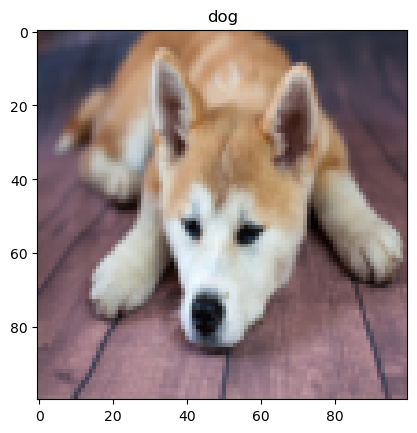

In [12]:
## 체크
img, target = next(iter(trainDL))
print(img.shape, target, IDX_TO_CLASS[target.item()])
plt.imshow(img[0].permute(1,2,0))
plt.title(IDX_TO_CLASS[target.item()])
plt.show()


(1) 데이터 준비 및 모듈 로딩

In [13]:
from torchvision import transforms as tf
from torchvision.datasets import ImageFolder

In [14]:
# 각종 LIB 충돌 방지를 위한 환경 설정
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [15]:
IMG_DIR = '../data/image/cat_dog/dog/'
RPS_DIR = '../data/rps/'

In [ ]:
## 이미지 데이터 저장
from PIL import Image

img = Image.open(IMG_DIR+'dog')

In [ ]:
if MIN_LOS

In [ ]:
## 모델 로딩 
model = torch.load(MODEL_DIR + MODEL_FILE, weights_only=True)
model